# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 18 апреля 2018, 06:00 <br\>
**Штраф за опоздание:** -3 балла после 06:00 18 апреля, -6 баллов после 06:00 25 апреля, -9 баллов после 06:00 2 мая

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw2.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

%matplotlib inline
%load_ext pycodestyle_magic

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [2]:
USER_NAME = u"Гультиков".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print ("Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
))

Имплементируйте обучение логистической регрессии с L2 регуляризацией с помощью метода Mini Batch Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту, т.е. в алгоритме надо
    * Перемешать выборку
    * Посчтитать градиент на одном объекте
    * Сделать шаг спуска
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Почитать градиент по мини батчам
    * Сделать шаг спуска
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в обучающей выборке (тем или иным способом)

### Примечание для случая L1-регуляризации:

При расчете производной по функции потерь
$$ L(w_0,w_1,\dots) = - \frac{1}{N}\left[\sum_i \log(\sigma(y^{(i)} g(x^{(i)}))\right] + \frac{1}{C}\sum_{j=1}^{m}|w_j| $$
могут возникнуть сомнения по поводу производной части с модулями. 

Вам на выбор предлагаются следующией варианты:
* Считать субградиент $\partial|w_j| = sign(w_j)$ (проще, но с большой вероятностью не приведет к занулению коэффициентов)
* Метод SGD-Clipping из [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.1, страница 479, правая колонка снизу (чуть сложнее, но зато должно занулять)
* Cumulative Penalty из той же [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.2

# Реализация модели

## Вывод правила обновления весов (1 балл)

Выведите правило обновления весов на каждом шаге алгоритма. Иными словами, посчитайте производную (градиент) функции потерь с регуляризацией. Формулы надо оформлять в формате LaTeX.

Минимизируем функцию потерь: 
$$
h\left(x^{(i)}, w\right) = \sigma(w^{T} x^{(i)} + w_0) = \frac{1}{1 + e^{-(w^{T}x^{(i)} + w_0)}}\\
$$
$$ L(w_0,w_1,\dots) = 
- \sum_{i=0}^{n} \Big(y^{(i)} \log\left(h\left(x^{(i)}, w\right)\right)
+  \left(1 - y^{(i)}\right) \log\left(1 - h\left(x^{(i)}, w\right)\right)\Big)
+ \frac{1}{C}\sum_{j=1}^{m}\left(w_j\right)^2 
$$
Градиент функции потерь с L2 регуляризацией
$$ \frac{\partial L}{\partial w_j} = \sum_{i=0}^{n} \Big( 
\frac{x_{j}}{1 + e^{w^{T}x^{(i)} + w_0}} -y^{(i)} x_{j}
\Big) + \frac{2}{C}w_j  = \sum_{i=0}^{n}  x_{j} \Big( h\left(x^{(i)}, w\right)
-y^{(i)}
\Big) + \frac{2}{C}w_j $$

## Имплементация (5 баллов)

In [30]:
#%%pycodestyle


from sklearn.base import BaseEstimator, ClassifierMixin


class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """

    # сигмоида
    def sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def h(self, x_elem):
        return self.sigmoid(-1.0 * x_elem.dot(self.w))

    # функция потерь
    def J(self, X, y):
        J = 0
        for i in range(self.n):
            sigma_ = self.sigmoid(-1.0 * np.dot(X[i], self.w))
            J += -y[i] * np.log(sigma_) - (1-y[i]) * np.log(1 - sigma_)
        J /= self.n
        return J

    def __init__(self, C=1.0, alpha=0.01, max_epoch=10, batches=50):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """

        self.C = float(C)
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batches = batches
        self.Loss = []

    def fit(self, X, y=None):
        '''
        Обучение модели
        '''
        # добавим единичный столбец
        x = np.append(np.ones(X.shape[0]).reshape(-1, 1), X, axis=1)

        self.n = np.shape(x)[0]  # колличество объектов
        self.m = np.shape(x)[1]  # колличество фичей

        self.w = np.ones(self.m)  # вектор параметров

        def grad(x, y_val):
            return x * (self.h(x) - y_val)

        for epoch in range(1, self.max_epoch + 1):
            # делим выборку на батчи
            inds = np.arange(self.n)
            np.random.shuffle(inds)
            batches = np.array_split(inds, self.batches)

            for batch in batches:
                for i in batch:
                    self.w += self.alpha / epoch * grad(x[i], y[i])
                    for ind in range(self.m):
                        self.w[ind] += 2.0 / self.C * self.alpha / epoch * self.w[ind]  # L2
            self.Loss.append(self.J(x, y))

        return self

    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
        return self

    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        y_hat = []
        x = np.append(np.ones(X.shape[0]).reshape(-1, 1), X, axis=1)
        for i in range(np.shape(x)[0]):
            if self.h(x[i]) > 0.5:
                y_hat.append(1)
            else:
                y_hat.append(0)
        return y_hat

    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''
        x = np.append(np.ones(X.shape[0]).reshape(-1, 1), X, axis=1)
        y_hat_proba = []
        for i in range(x.shape[0]):
            y_hat_proba.append(self.h(x[i]))
        return y_hat_proba

## Проверка на синтетических данных (1 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

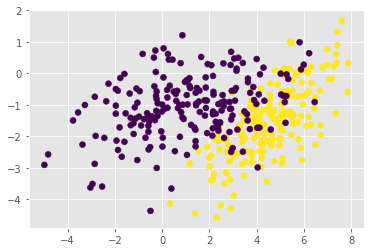

In [31]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

plt.scatter(X[:,0], X[:,1], c=y)

In [32]:
my_sgd = MySGDClassifier(C=100, alpha=0.01, max_epoch=200, batches=100)
my_sgd.fit(X, y)
y_predicited = my_sgd.predict(X)
accuracy_score(y, y_predicited)


0.895

[ 3.39635746 -0.82830442  0.78295312]


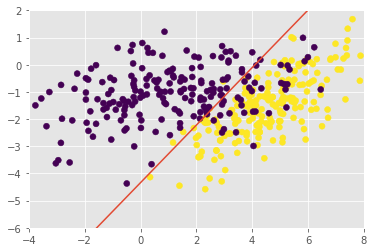

In [33]:
print (my_sgd.w)
plt.plot ([-4,8], [(4 * my_sgd.w[1] - my_sgd.w[0]) / my_sgd.w[2], (-8* my_sgd.w[1] - my_sgd.w[0]) / my_sgd.w[2]])
plt.scatter(X[:,0], X[:,1], c=y)
axes = plt.gca()
axes.set_xlim([-4,8])
axes.set_ylim([-6,2])
plt.show ()

## Анализ сходимости (2 балла)

Для следующих заданий используйте датасет ниже

In [34]:
from sklearn.datasets import make_classification

In [36]:
X, y = make_classification(n_samples=10000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

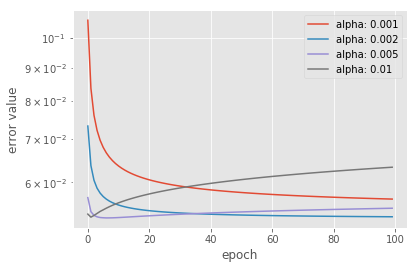

In [38]:
## Your Code Here
for alpha in [0.001, 0.002, 0.005, 0.01]:
    my_sgd = MySGDClassifier(C=1000, alpha=alpha, max_epoch=100, batches=50)
    my_sgd.fit(X, y)
    plt.plot(my_sgd.Loss, label=('alpha: ' + str(alpha)))
    plt.yscale('log')
plt.xlabel("epoch")
plt.ylabel("error value")
plt.legend()

## Эффект регуляризации (2 балла)

Изобразите значения коэффициентов модели для каждого С из `np.logspace(3, -3, 10)` (желательно на одном и том же графике)

In [39]:
## Your Code Here
params = np.empty([10, X.shape[1]+1])
C = np.logspace(3, -3, 10)
for i, c in enumerate(C):
    my_sgd = MySGDClassifier(C=c, alpha=0.001, max_epoch=100, batches=50)
    my_sgd.fit(X, y)
    params[i] = my_sgd.w

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log
E:\Anaconda\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in multiply
E:\Anaconda\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in exp
  


E:\Anaconda\lib\site-packages\matplotlib\scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


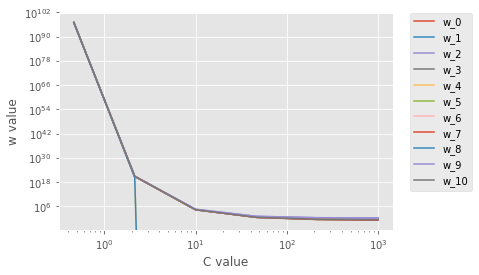

In [40]:
for i in range(np.shape(params)[1]):
    plt.plot(C, params[:, i], label='w_' + str(i))
    plt.xscale('log')
    plt.yscale('log')
plt.ylabel('w value')
plt.xlabel('C value')
#axes = plt.gca()
#axes.set_ylim([-1,10])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Боевое применение

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

## Данные

Обучающую выборку и тестовую выборку с ответами можно скачать [отсюда](https://cloud.mail.ru/public/BEon/4Rrdqqvng)

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если все данные не будут помещаться вам с оперативную память, то можете использовать один из 4х файлов для обучения

In [41]:
# Загрузка данных целиком
# df_list = []
# for chunk in range(1,5):
#     filepath = './trainingData_tabular_chunk%d.csv' % chunk
#     df_list.append(pd.read_csv(filepath, sep=','))
# df_data = pd.concat(df_list)

# Загрузка одной части данных
filepath = './trainingData_tabular_chunk1.csv'
df_data = pd.read_csv(filepath, sep=',')

In [42]:
df_data.shape

(500000, 45)

In [43]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [44]:
df_data.head().T

gamestate_id,4687346,3270826,3189487,4098946,2661127
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hero_card_id,798,754,612,390,25
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1


In [45]:
# Распределение классов
df_data.decision.mean()

# Примерно поровну

0.504702

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощью one-hot кодирования, добавьте к датасету и удалите прежние столбцы


In [46]:
## Youd Code Here
opponent_unique_cards = df_data.opponent_hero_card_id.unique()
player_unique_cards = df_data.player_hero_card_id.unique()

print("unique opponent cards: ", len(opponent_unique_cards))
print("unique player cards: ", len(player_unique_cards))

unique opponent cards:  9
unique player cards:  9


In [47]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()

player_values_test = enc.fit_transform(
    df_data.player_hero_card_id.values.reshape(-1, 1)).toarray().astype(int)

opponent_values_test = OneHotEncoder().fit_transform(
    df_data.opponent_hero_card_id.values.reshape(-1, 1)).toarray().astype(int)

player_columns = ["player_hero_card_id_" + "%d" % n for n in range(1, player_unique_cards.shape[0] + 1)]
opponent_columns = ["opponent_hero_card_id_" + "%d" % n for n in range(1, opponent_unique_cards.shape[0] + 1)]
df_train_data = pd.concat([df_data,
                           pd.DataFrame(player_values_test, columns=player_columns,
                                        index=df_data.index),
                           pd.DataFrame(opponent_values_test, columns=opponent_columns,
                                        index=df_data.index)],
                           axis=1)

df_train_data.drop(['opponent_hero_card_id', 'player_hero_card_id'], axis=1, inplace=True)

In [48]:
df_train_data.head().T

gamestate_id,4687346,3270826,3189487,4098946,2661127
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1
opponent_deck_count,11,19,22,17,12


## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Создайте Pipeline из `StandartScaller` и вашей модели
* Обучите модель (подбирать гиперпараметры можно без фанатизма)

In [49]:
## Youd Code Here
X = df_train_data.drop ('decision', axis=1)
y = df_train_data.decision.values

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
model = MySGDClassifier(C=1000, alpha=0.001, max_epoch=100, batches=50)

scale_model = Pipeline([('scaler', scaler), ('model',model)])
scale_model.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', MySGDClassifier(C=1000.0, alpha=0.001, batches=50, max_epoch=100))])

## Применение модели (2 балла)
#### Задание
* Загрузите тестовые данные
* Подготовте их к подаче на вход в алгоритм
* Примените модель оцените качество с помощью меры ROC-AUC


In [50]:
## Youd Code Here
## Youd Code Here
df_list = []
for chunk in range(5,8):
    filepath = './testData_tabular_chunk%d.csv' % chunk
    df_list.append(pd.read_csv(filepath, sep=','))
df_test_data = pd.concat(df_list)

In [51]:
df_test_data.shape

(1250000, 45)

In [52]:
# для удобства
df_test_data.columns = df_test_data.columns.str.replace('.', '_')
df_test_data = df_test_data.set_index('gamestate_id')

In [53]:
df_test_data.head().T

gamestate_id,1304374.0,4383331.0,3544947.0,4282915.0,4327924.0
decision,NaN,NaN,NaN,NaN,NaN
turn,5.0,9.0,16.0,3.0,5.0
opponent_armor,0.0,0.0,0.0,0.0,0.0
opponent_attack,0.0,3.0,0.0,0.0,0.0
opponent_hero_card_id,981.0,754.0,798.0,326.0,25.0
opponent_hp,23.0,16.0,16.0,30.0,30.0
opponent_special_skill_used,0.0,0.0,1.0,0.0,0.0
opponent_weapon_durability,0.0,1.0,0.0,0.0,0.0
opponent_crystals_all,4.0,8.0,10.0,2.0,4.0
opponent_crystals_current,0.0,3.0,2.0,2.0,1.0


In [55]:
opponent_unique_cards = df_test_data.opponent_hero_card_id.unique ()
player_unique_cards = df_test_data.player_hero_card_id.unique ()

enc = OneHotEncoder()
player_values_test = enc.fit_transform(
    df_test_data.player_hero_card_id.values.reshape(-1, 1)).toarray().astype(int)

opponent_values_test = OneHotEncoder().fit_transform(
    df_test_data.opponent_hero_card_id.values.reshape(-1, 1)).toarray().astype(int)

player_columns = ["player_hero_card_id_" + "%d" % n for n in range(1, player_unique_cards.shape[0] + 1)]
opponent_columns = ["opponent_hero_card_id_" + "%d" % n for n in range(1, opponent_unique_cards.shape[0] + 1)]
df_test_modified_data = pd.concat([df_test_data,
                           pd.DataFrame(player_values_test, columns=player_columns,
                                        index=df_test_data.index),
                           pd.DataFrame(opponent_values_test, columns=opponent_columns,
                                        index=df_test_data.index)],
                           axis=1)

df_test_modified_data.drop(['opponent_hero_card_id', 'player_hero_card_id'], axis=1, inplace=True)

In [56]:
df_test_modified_data.head().T

gamestate_id,1304374.0,4383331.0,3544947.0,4282915.0,4327924.0
decision,NaN,NaN,NaN,NaN,NaN
turn,5.0,9.0,16.0,3.0,5.0
opponent_armor,0.0,0.0,0.0,0.0,0.0
opponent_attack,0.0,3.0,0.0,0.0,0.0
opponent_hp,23.0,16.0,16.0,30.0,30.0
opponent_special_skill_used,0.0,0.0,1.0,0.0,0.0
opponent_weapon_durability,0.0,1.0,0.0,0.0,0.0
opponent_crystals_all,4.0,8.0,10.0,2.0,4.0
opponent_crystals_current,0.0,3.0,2.0,2.0,1.0
opponent_deck_count,21.0,17.0,9.0,24.0,22.0


In [57]:
X_test = df_test_modified_data.drop('decision', axis=1)

scores = model.predict_proba(X_test)
scores

[2.7953723524494354e-115,
 2.6934585924336234e-108,
 1.0610629579787426e-131,
 3.735399936788761e-116,
 1.1035364899397305e-105,
 6.816213624155243e-114,
 1.1106951687053335e-123,
 4.903268123231407e-115,
 9.006404230340048e-87,
 3.8801332236361085e-107,
 5.365001426141025e-140,
 7.674459719659473e-141,
 1.665820873428737e-98,
 1.6958818319313202e-100,
 4.89617137323134e-109,
 6.0630397355747994e-117,
 3.2030981479159517e-137,
 1.6009199494501104e-94,
 2.109677022858787e-108,
 5.376420202868969e-117,
 3.6527886217611604e-116,
 3.144814864233706e-118,
 4.0414468034963577e-103,
 1.2010510625757203e-121,
 9.272667947101292e-109,
 3.059289643192662e-82,
 3.923053819679045e-110,
 4.520450062748127e-75,
 7.500743158790893e-57,
 4.1932356633761435e-113,
 7.188041898553426e-116,
 5.7997914801689614e-71,
 4.577318017429993e-99,
 6.242082569825193e-117,
 9.652012736232171e-114,
 3.3789353071610297e-99,
 3.2094236647828005e-108,
 4.953285579214308e-130,
 8.611692248310156e-76,
 1.5694661750769361

In [59]:
from sklearn.metrics import roc_auc_score

y_test = np.loadtxt('deprecated_testLabels.txt')

print('ROC_AUC:', roc_auc_score(y_test, scores))

ROC_AUC: 0.549823253524156
